<a href="https://colab.research.google.com/github/ArshanBhanage/Clustering/blob/main/Gaussian_Mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab notebook demonstrates **Gaussian Mixture Models (GMM) clustering** using the **Palmer Penguins dataset**.

The notebook covers the following steps:

1.  **Data Loading and Preparation**: Loads the Palmer Penguins dataset, selects relevant numerical features, handles missing values, and converts the 'species' column to numerical codes for evaluation.
2.  **Data Preprocessing**: Scales the features using `StandardScaler` to ensure all features contribute equally to the clustering process.
3.  **GMM Clustering**: Applies Gaussian Mixture Models with 3 components (corresponding to the 3 penguin species) to the scaled data.
4.  **Evaluation**: Evaluates the clustering performance using the Silhouette Score (an unsupervised metric) and the Adjusted Rand Index (comparing clusters to the true species labels for reference).
5.  **Visualization**: Reduces the data to 2 dimensions using Principal Component Analysis (PCA) and visualizes the GMM clusters and their means.
6.  **Model Selection**: Explores different numbers of components for the GMM and uses the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) to help determine the optimal number of clusters.
7.  **Probability Analysis**: Calculates and displays the posterior probabilities of each data point belonging to different clusters.

In [1]:
# Gaussian Mixture Models (GMM) clustering using the Palmer Penguins dataset

!pip install -q datasets

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datasets import load_dataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score


In [2]:
# Load the palmerpenguins dataset from HuggingFace
dataset = load_dataset("SIH/palmer-penguins")["train"]
df = dataset.to_pandas()

df.head()


README.md: 0.00B [00:00, ?B/s]

penguins.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/344 [00:00<?, ? examples/s]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,None,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:
# Select numeric features for clustering
numeric_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

df = df[numeric_cols + ["species"]].dropna()

X = df[numeric_cols].values
y_true = df["species"].astype("category").cat.codes.values  # convert species to ints

print("Dataset shape:", X.shape)
print(df.head())


Dataset shape: (342, 4)
   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g species
0            39.1           18.7              181.0       3750.0  Adelie
1            39.5           17.4              186.0       3800.0  Adelie
2            40.3           18.0              195.0       3250.0  Adelie
4            36.7           19.3              193.0       3450.0  Adelie
5            39.3           20.6              190.0       3650.0  Adelie


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature shape:", X_scaled.shape)


Scaled feature shape: (342, 4)


In [5]:
# Penguins have 3 species, so n_components=3
gmm = GaussianMixture(
    n_components=3,
    covariance_type="full",
    random_state=42
)

gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)

print("Cluster labels (first 20):", labels[:20])


Cluster labels (first 20): [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [6]:
# Unsupervised quality measure
sil_score = silhouette_score(X_scaled, labels)
print("Silhouette Score:", sil_score)

# Compare to true species (just for reference)
ari = adjusted_rand_score(y_true, labels)
print("Adjusted Rand Index (vs true species):", ari)


Silhouette Score: 0.45454862870063617
Adjusted Rand Index (vs true species): 0.9603061495108168


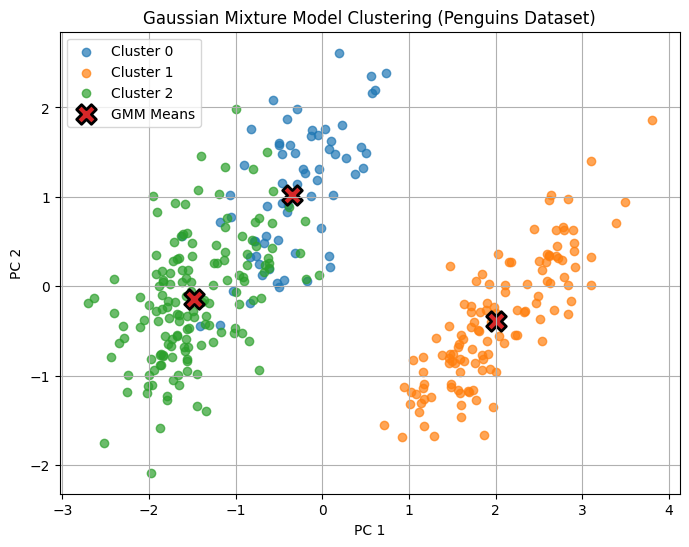

In [7]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
centroids_2d = pca.transform(gmm.means_)  # transform GMM means to PCA space

plt.figure(figsize=(8,6))
for cluster_id in range(3):
    mask = labels == cluster_id
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], alpha=0.7, label=f"Cluster {cluster_id}")

# Plot GMM means (centroids)
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    marker="X", s=200, edgecolor="black", linewidth=2, label="GMM Means"
)

plt.title("Gaussian Mixture Model Clustering (Penguins Dataset)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


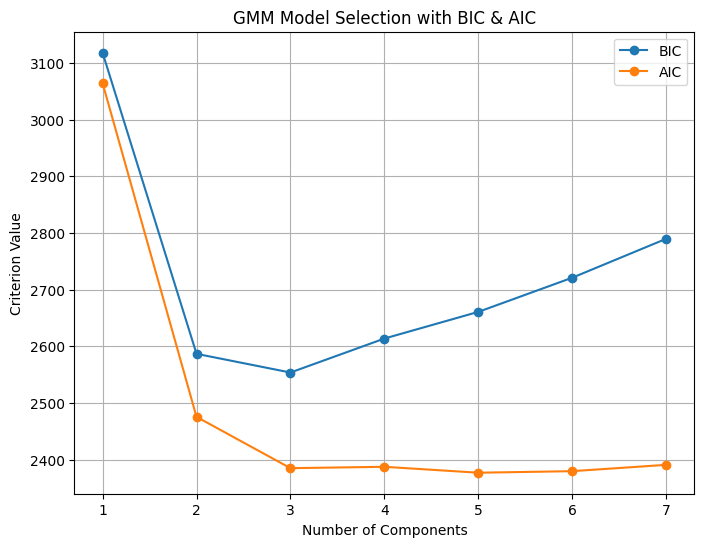

In [8]:
components_range = range(1, 8)
bics, aics = [], []

for n in components_range:
    gm = GaussianMixture(
        n_components=n,
        covariance_type="full",
        random_state=42
    )
    gm.fit(X_scaled)
    bics.append(gm.bic(X_scaled))
    aics.append(gm.aic(X_scaled))

plt.figure(figsize=(8,6))
plt.plot(components_range, bics, marker="o", label="BIC")
plt.plot(components_range, aics, marker="o", label="AIC")
plt.xlabel("Number of Components")
plt.ylabel("Criterion Value")
plt.title("GMM Model Selection with BIC & AIC")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
probs = gmm.predict_proba(X_scaled)
print("Posterior cluster probabilities (first 5 samples):")
print(np.round(probs[:5], 3))

print("\nAverage max probability:", probs.max(axis=1).mean())


Posterior cluster probabilities (first 5 samples):
[[0.    0.    1.   ]
 [0.001 0.    0.999]
 [0.035 0.    0.965]
 [0.    0.    1.   ]
 [0.    0.    1.   ]]

Average max probability: 0.9908607973388575
